# Lambda School Data Science Module 142
## Sampling, Confidence Intervals, and Hypothesis Testing

## Prepare - examine other available hypothesis tests

If you had to pick a single hypothesis test in your toolbox, t-test would probably be the best choice - but the good news is you don't have to pick just one! Here's some of the others to be aware of:

In [1]:
import numpy as np
from scipy.stats import chisquare  # One-way chi square test

# Chi square can take any crosstab/table and test the independence of rows/cols
# The null hypothesis is that the rows/cols are independent -> low chi square
# The alternative is that there is a dependence -> high chi square
# Be aware! Chi square does *not* tell you direction/causation

ind_obs = np.array([[1, 1], [2, 2]]).T

print(ind_obs)

print(chisquare(ind_obs, axis=None))

dep_obs = np.array([[16, 18, 16, 14, 12, 12], [32, 24, 16, 28, 20, 24]]).T

print(dep_obs)
print(chisquare(dep_obs, axis=None))

[[1 2]
 [1 2]]
Power_divergenceResult(statistic=0.6666666666666666, pvalue=0.8810148425137847)
[[16 32]
 [18 24]
 [16 16]
 [14 28]
 [12 20]
 [12 24]]
Power_divergenceResult(statistic=23.31034482758621, pvalue=0.015975692534127565)


In [2]:
# Distribution tests:
# We often assume that something is normal, but it can be important to *check*

# For example, later on with predictive modeling, a typical assumption is that
# residuals (prediction errors) are normal - checking is a good diagnostic

from scipy.stats import normaltest
# Poisson models arrival times and is related to the binomial (coinflip)
sample = np.random.poisson(5, 1000)
print(normaltest(sample))  # Pretty clearly not normal

NormaltestResult(statistic=34.25734085820535, pvalue=3.640096946142771e-08)


In [3]:
# Kruskal-Wallis H-test - compare the median rank between 2+ groups
# Can be applied to ranking decisions/outcomes/recommendations
# The underlying math comes from chi-square distribution, and is best for n>5
from scipy.stats import kruskal

x1 = [1, 3, 5, 7, 9]
y1 = [2, 4, 6, 8, 10]
print(kruskal(x1, y1))  # x1 is a little better, but not "significantly" so

x2 = [1, 1, 1]
y2 = [2, 2, 2]
z = [2, 2]  # Hey, a third group, and of different size!
print(kruskal(x2, y2, z))  # x clearly dominates

KruskalResult(statistic=0.2727272727272734, pvalue=0.6015081344405895)
KruskalResult(statistic=7.0, pvalue=0.0301973834223185)


And there's many more! `scipy.stats` is fairly comprehensive, though there are even more available if you delve into the extended world of statistics packages. As tests get increasingly obscure and specialized, the importance of knowing them by heart becomes small - but being able to look them up and figure them out when they *are* relevant is still important.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy import stats


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


## Live Lecture - let's explore some more of scipy.stats

Candidate topics to explore:

- `scipy.stats.chi2` - the Chi-squared distribution, which we can use to reproduce the Chi-squared test
- Calculate the Chi-Squared test statistic "by hand" (with code), and feed it into `chi2`
- Build a confidence interval with `stats.t.ppf`, the t-distribution percentile point function (the inverse of the CDF) - we can write a function to return a tuple of `(mean, lower bound, upper bound)` that you can then use for the assignment (visualizing confidence intervals)

In [5]:
df = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/adult.csv", na_values=' ?')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [6]:
df.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
country            583
salary               0
dtype: int64

In [7]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [8]:
df.describe(exclude='number')

,workclass,education,marital-status,occupation,relationship,race,sex,country,salary
count,30725,32561,32561,30718,32561,32561,32561,31978,32561
unique,8,16,7,14,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


In [9]:
#df['hours-per-week']

In [10]:

cut_points = [0,9,19,29,39,49,1000]

label_names = ['0-9','10-19','20-29','30-39','40-49','50 +']

df['hours_per_week_categories'] = pd.cut(df['hours-per-week'], cut_points, labels = label_names)

df.head()




,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary,hours_per_week_categories
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,40-49
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,10-19
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,40-49
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,40-49
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,40-49


In [11]:
df['sex'].iloc[0]

' Male'

In [12]:
df['hours_per_week_categories'].iloc[0]

'40-49'

In [13]:
df['sex'].value_counts()

 Male      21790
 Female    10771
Name: sex, dtype: int64

In [14]:
df['hours_per_week_categories'].value_counts()

40-49    18336
50 +      6462
30-39     3667
20-29     2392
10-19     1246
0-9        458
Name: hours_per_week_categories, dtype: int64

In [15]:
df = df.sort_values(by='hours_per_week_categories', ascending=True)

df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary,hours_per_week_categories
31290,55,Self-emp-not-inc,41938,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,0,8,United-States,<=50K,0-9
5172,32,NaN,134886,HS-grad,9,Married-civ-spouse,NaN,Wife,White,Female,0,0,2,United-States,>50K,0-9
22928,17,NaN,332666,10th,6,Never-married,NaN,Own-child,White,Female,0,0,4,United-States,<=50K,0-9
7902,35,Private,359131,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,White,Female,7298,0,8,NaN,>50K,0-9
6604,41,Private,406603,HS-grad,9,Never-married,Other-service,Not-in-family,White,Male,0,0,6,Iran,<=50K,0-9


In [16]:
contingency_table = pd.crosstab(df['sex'], df['hours_per_week_categories'], margins=True)
contingency_table

hours_per_week_categories,0-9,10-19,20-29,30-39,40-49,50 +,All
sex,,,,,,,
Female,235,671,1287,1914,5636,1028,10771
Male,223,575,1105,1753,12700,5434,21790
All,458,1246,2392,3667,18336,6462,32561


In [17]:
femalecount = contingency_table.iloc[0,0:6]
femalecount

hours_per_week_categories
0-9       235
10-19     671
20-29    1287
30-39    1914
40-49    5636
50 +     1028
Name:  Female, dtype: int64

In [18]:
malecount = contingency_table.iloc[1,0:6]
malecount

hours_per_week_categories
0-9        223
10-19      575
20-29     1105
30-39     1753
40-49    12700
50 +      5434
Name:  Male, dtype: int64

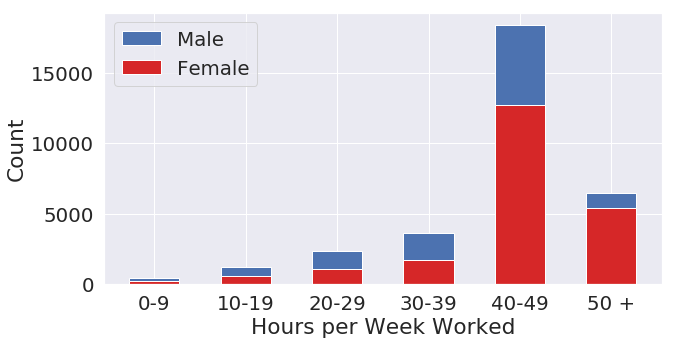

In [19]:
fig = plt.figure(figsize=(10, 5))

sns.set(font_scale=1.8)

categories = ['0-9','10-19','20-29','30-39','40-49','50 +']

p1 = plt.bar(categories, malecount, .55, color = '#d62728')

p2 = plt.bar(categories, femalecount, 0.55,bottom = malecount)

plt.legend((p2[0],p1[0]),('Male','Female'))

plt.xlabel('Hours per Week Worked')

plt.ylabel('Count')

plt.show;









In [24]:
contingency_table

hours_per_week_categories,0-9,10-19,20-29,30-39,40-49,50 +,All
sex,,,,,,,
Female,235,671,1287,1914,5636,1028,10771
Male,223,575,1105,1753,12700,5434,21790
All,458,1246,2392,3667,18336,6462,32561


In [25]:
row_sums = contingency_table.iloc[0:2,6].values
col_sums = contingency_table.iloc[2, 0:6].values

print(row_sums)
print(col_sums)

[10771 21790]
[  458  1246  2392  3667 18336  6462]


In [21]:
total = contingency_table.loc['All','All']

In [22]:
contingency_table

hours_per_week_categories,0-9,10-19,20-29,30-39,40-49,50 +,All
sex,,,,,,,
Female,235,671,1287,1914,5636,1028,10771
Male,223,575,1105,1753,12700,5434,21790
All,458,1246,2392,3667,18336,6462,32561


In [120]:
expected = []
for i in range(len(row_sums)):
    expected_row = []
    for column in col_sums:
        expected_val = column*row_sums[i]/total
        expected_row.append(expected_val)
    expected.append(expected_row)

print(np.array(expected))
    
    

[[  151.50388502   412.16995793   791.26046497  1213.02346365
   6065.44811277  2137.59411566]
 [  306.49611498   833.83004207  1600.73953503  2453.97653635
  12270.55188723  4324.40588434]]


In [124]:
observed = pd.crosstab(df['sex'], df['hours_per_week_categories']).values
observed

array([[  235,   671,  1287,  1914,  5636,  1028],
       [  223,   575,  1105,  1753, 12700,  5434]])

In [126]:
chi_squared = ((observed - expected)**2/(expected)).sum()

print(f"Chi-squared: {chi_squared}")

Chi-squared: 2287.190943926107


In [127]:
dof = (len(row_sums)-1)*(len(col_sums)-1)

print(f"Degrees of Freedom: {dof}")


Degrees of Freedom: 5


In [129]:
chi_squared, p_value, dof, expected = stats.chi2_contingency(observed)

print(f"Chi-Squared: {chi_squared}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}") 
print("Expected: \n", np.array(expected))

Chi-Squared: 2287.190943926107
P-value: 0.0
Degrees of Freedom: 5
Expected: 
 [[  151.50388502   412.16995793   791.26046497  1213.02346365
   6065.44811277  2137.59411566]
 [  306.49611498   833.83004207  1600.73953503  2453.97653635
  12270.55188723  4324.40588434]]


In [136]:
coinflip = np.random.binomial(n=1, p=.5, size=100)
print(coinflip)

[1 1 0 0 0 0 0 0 1 0 0 1 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1 0 0 1 1 1 0 0 1 0 0
 0 1 1 0 0 1 1 0 1 0 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 1 0 0 0 0 1 1 1 0 1 0 1
 0 0 1 1 0 0 0 1 1 1 1 0 1 1 0 0 0 1 0 0 1 1 0 1 0 1]


In [138]:
stats.ttest_1samp(coinflip, .5)


Ttest_1sampResult(statistic=0.19903729886263904, pvalue=0.8426417731724416)

In [140]:
coinflips_100 = np.random.binomial(n=1, p=.5, size=100)
coinflips_1000 = np.random.binomial(n=1, p=.5, size=1000)

print("100 Coinflips Mean:", coinflips_100.mean())
print("1000 Coinflips Mean:", coinflips_1000.mean())

print("100 Coinflips Standard Deviation:", np.std(coinflips_100))
print("1000 Coinflips Standard Deviation:", np.std(coinflips_1000))



100 Coinflips Mean: 0.47
1000 Coinflips Mean: 0.525
100 Coinflips Standard Deviation: 0.49909918853871116
1000 Coinflips Standard Deviation: 0.4993746088859544


In [160]:
'''
def confidence_interval(data, confidence=0.95):

    data = np.array(data)
    mean = np.mean(data)
    n = len(data)
  

    stderr = stats.sem(data)
    
    
    interval = stderr * stats.t.ppf((1 + confidence) / 2.0, n - 1)
    return (mean, mean - interval, mean + interval)



#def report_confidence_interval(confidence_interval):

  
#    s = "our mean lies in the interval [{:.5}, {:.5}]".format(confidence_interval[1], confidence_interval[2])
#    return s'''

In [154]:
report_confidence_interval(confidence_interval(coinflips_100))

'our mean lies in the interval [0.37047, 0.56953]'

In [155]:
report_confidence_interval(confidence_interval(coinflips_1000))

'our mean lies in the interval [0.494, 0.556]'

In [161]:
stats.t.ppf(.05, 5)


-2.0150483726691575

## Assignment - Build a confidence interval


Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):

1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

In [163]:
def ci(data, confidence=0.95):

    data = np.array(data)
    mean = np.mean(data)
    n = len(data)
  

    stderr = stats.sem(data)
    
    
    interval = stderr * stats.t.ppf((1 + confidence) / 2.0, n - 1)
    return (mean, mean - interval, mean + interval)



def print_(confidence_interval):

  
    s = "our mean lies in the interval [{:.5}, {:.5}]".format(confidence_interval[1], confidence_interval[2])
    return s

In [306]:
column_header=[ 
    'party','HC infants' , 'water', 'budget resolution', 'physician fee','salvador aid' , 'religion-in-schools' ,
    'anti-satellite', 'nicaraguan contras' ,'mx missile', 'immigration','synfuels', 'education-spending' , 'right to sue',
    'crime', 'free exports' ,'south africa']


df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data',names=column_header,header=1)

In [316]:
df = df.replace({ 'y':1, 'n':0, '?':.5 })

rep = df[df['party'] == 'republican']
dem = df[df['party'] == 'democrat']
df.head()

,party,HC infants,water,budget resolution,physician fee,salvador aid,religion-in-schools,anti-satellite,nicaraguan contras,mx missile,immigration,synfuels,education-spending,right to sue,crime,free exports,south africa
0,democrat,0.5,1.0,1.0,0.5,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
1,democrat,0.0,1.0,1.0,0.0,0.5,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.5,1.0,1.0,1.0,1.0
3,democrat,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
4,democrat,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,1.0,1.0,1.0


In [320]:
t_dem = dem.iloc[0:,1:].mean().values
t_rep = rep.iloc[0:,1:].mean().values


In [321]:
print(t_dem)

[0.6011236  0.50187266 0.87827715 0.06741573 0.22846442 0.47752809
 0.76404494 0.82397004 0.73970037 0.47191011 0.50561798 0.16853933
 0.30149813 0.35580524 0.62921348 0.80149813]


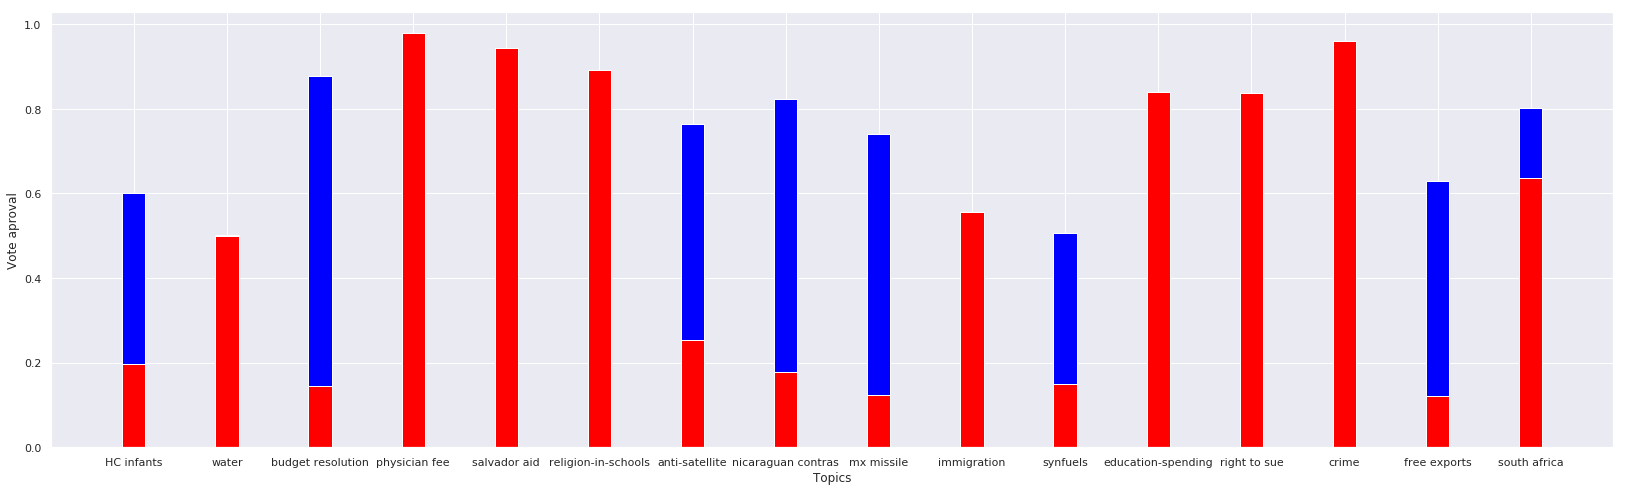

In [345]:

categories = ['HC infants' , 'water', 'budget resolution', 'physician fee','salvador aid' , 'religion-in-schools' ,
    'anti-satellite', 'nicaraguan contras' ,'mx missile', 'immigration','synfuels', 'education-spending' , 'right to sue',
    'crime', 'free exports' ,'south africa']

fig = plt.figure(figsize=(28, 8))
sns.set(font_scale=1)

ax = plt.bar(categories, t_dem, 0.25, color='blue')
ax = plt.bar(categories, t_rep,  0.25, color='red')
#plt.legend((p1[1]), ('Male'))
plt.xlabel('Topics')
plt.ylabel('Vote aproval')
plt.show()

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)